In [1]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
from modelzz import U_net
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)

In [2]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
IMG_SIZE=128
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [3]:
def show_imgs(paths, i):
    sub_path = sorted(os.listdir(TRAIN_DATASET_PATH + paths[i]))
    
    image_flair = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' +sub_path[0]).get_fdata()
    mask = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[1]).get_fdata()
    image_t1 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[2]).get_fdata()
    image_t1ce = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[3]).get_fdata()
    image_t2 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[4]).get_fdata()
    
    print(f"Height of the image: {image_flair.shape[0]}")
    print(f"width of the image: {image_flair.shape[1]}")
    print(f"number of slices of volume of the image: {image_flair.shape[-1]}")
    print()
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
    slice_w = 25
    ax1.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w], cmap = 'gray')
    ax1.set_title('Image flair')
    ax1.axis(False)
    ax2.imshow(image_t1[:,:,image_t1.shape[0]//2-slice_w], cmap = 'gray')
    ax2.set_title('Image t1')
    ax2.axis(False)
    ax3.imshow(image_t1ce[:,:,image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
    ax3.set_title('Image t1ce')
    ax3.axis(False)
    ax4.imshow(image_t2[:,:,image_t2.shape[0]//2-slice_w], cmap = 'gray')
    ax4.set_title('Image t2')
    ax4.axis(False)
    ax5.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w], cmap="OrRd", alpha=1.0)
    ax5.imshow(mask[:,:,mask.shape[0]//2-slice_w], alpha=0.2, cmap="OrRd")
    ax5.set_title('Mask')
    ax5.axis(False)
    print()
#     plt.imshow(mask, cmap='reds')
    plt.show()
    

Height of the image: 240
width of the image: 240
number of slices of volume of the image: 155




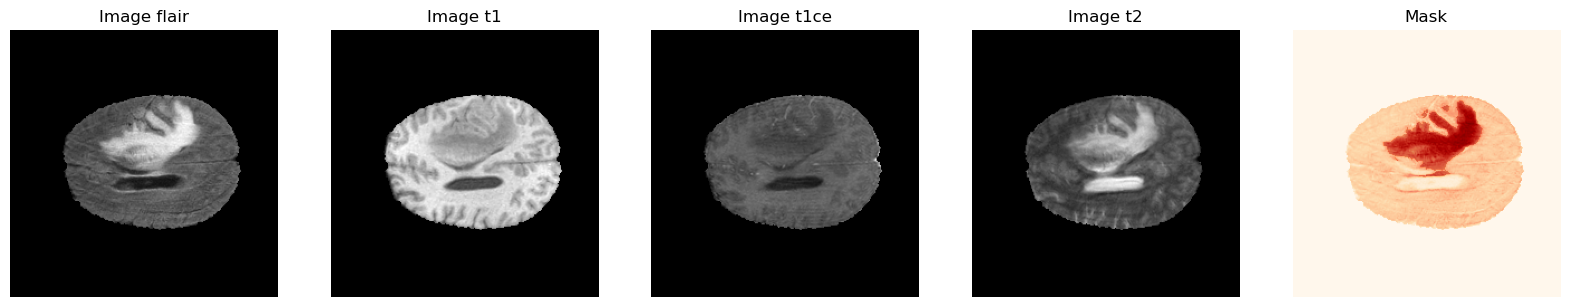

In [4]:
path = sorted(os.listdir(r"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"))
show_imgs(path, 0) # with Tumor

Height of the image: 240
width of the image: 240
number of slices of volume of the image: 155




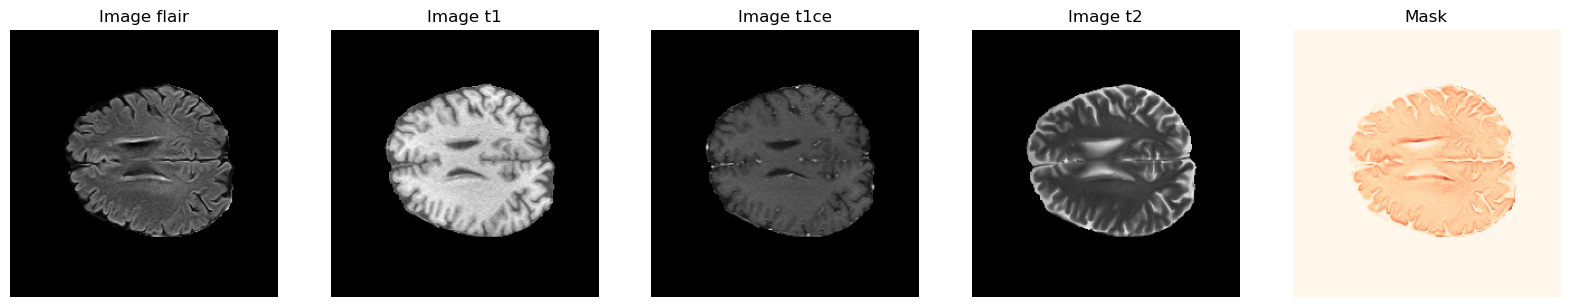

In [5]:
show_imgs(path, 100) #without Tumor

In [6]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [7]:
print("no. of training samples:", len(train_ids))
print("no. of validation samples:", len(val_ids))
print("no. of test samples:", len(test_ids))

no. of training samples: 249
no. of validation samples: 74
no. of test samples: 45


In [8]:
def generate_data(list_ids, batch_size, img_size):
    while True:
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        indexes = np.arange(len(list_ids))
    #     indexes = indexes[index*batch_size:(index+1)*batch_size]
        np.random.shuffle(indexes)
        Batch_ids = [list_ids[k] for k in indexes[:batch_size]]

        # Initialization
        X = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], img_size[2]))
        y = np.zeros((batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))   
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, len(SEGMENT_CLASSES))
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        yield X/np.max(X), Y
        

def data_generator_wrapper(list_ids, batch_size=1, img_size=(IMG_SIZE, IMG_SIZE, 2)):
    if len(list_ids)==0 or batch_size<=0: return None
    return generate_data(list_ids, batch_size, img_size)

In [9]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [11]:
unet = U_net((IMG_SIZE, IMG_SIZE, 2), dropout=0.2, classes=len(SEGMENT_CLASSES))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

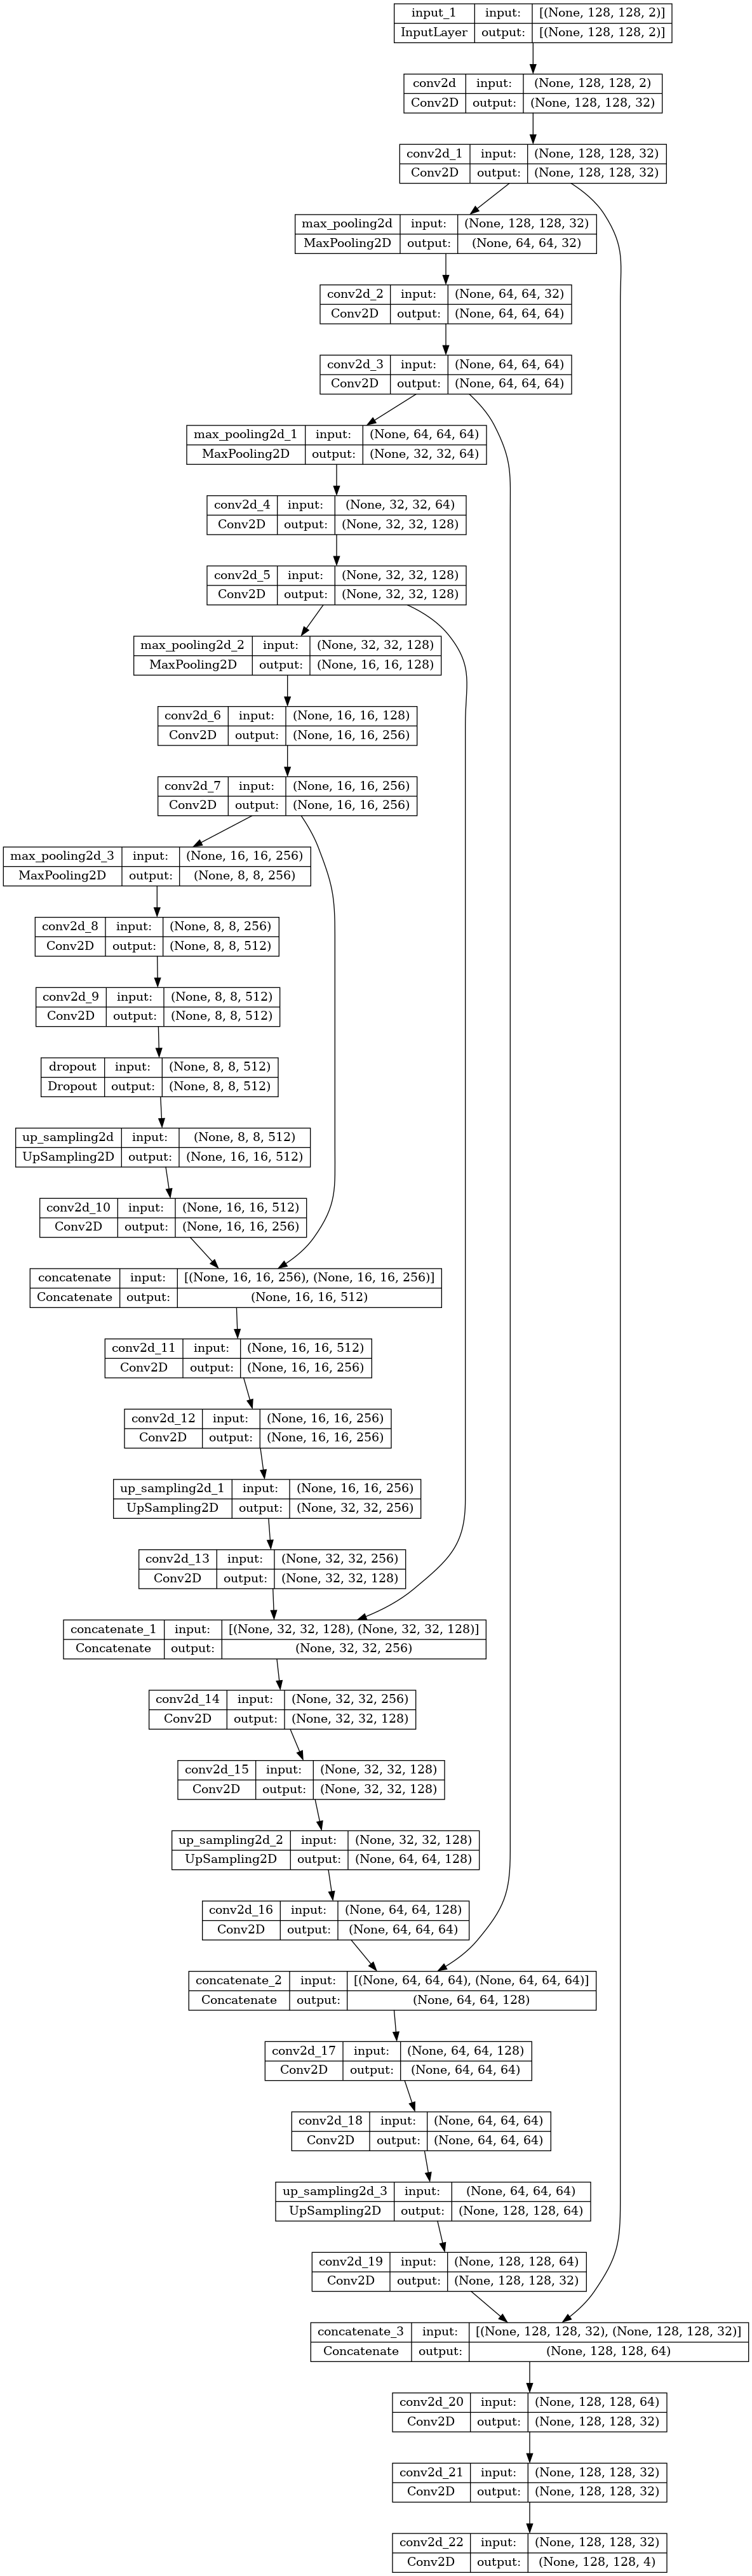

In [12]:
tf.keras.utils.plot_model(unet, show_shapes = True, expand_nested = False, to_file='unet_model.png')

In [13]:
unet.compile(loss="categorical_crossentropy", optimizer='adam', 
             metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(SEGMENT_CLASSES)), 
                        dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                        dice_coef_edema ,dice_coef_enhancing])

In [14]:
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
checkpoints_cb = ModelCheckpoint("unet_weights_vir.h5", save_best_only=True, verbose=1)
reducee_lr_cb = ReduceLROnPlateau(patience=3, verbose=1)

# # TensorBoard Support
# # tensorboard --logdir=./my_logs_vir --port=5050
# root_logdir = os.path.join(os.curdir, "my_logs_vir")
# def get_run_logdir():
#     import time
#     run_id = time.strftime("run_%Y_%m_%d-#H_%M_%S")
#     return os.path.join(root_logdir, run_id)
# run_logdir = get_run_logdir()
# tensorboard_cb = TensorBoard(run_logdir)

callbackss = [checkpoints_cb, reducee_lr_cb, early_stopping_cb]

In [15]:
batch_size=1
history = unet.fit(data_generator_wrapper(train_ids, batch_size=batch_size), 
                    epochs=35,
                    steps_per_epoch=max(1, len(train_ids)//batch_size), 
                    validation_data=data_generator_wrapper(val_ids, batch_size=batch_size), 
                    validation_steps=max(1, len(val_ids)//batch_size), 
                    initial_epoch=0, 
                    callbacks = callbackss)

Epoch 1/35


2023-04-15 10:45:46.706283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9790 - mean_io_u: 0.5333 - dice_coef: 0.2619 - precision: 0.9584 - sensitivity: 0.9474 - specificity: 0.9946 - dice_coef_necrotic: 0.0536 - dice_coef_edema: 0.1132 - dice_coef_enhancing: 0.0358
Epoch 1: val_loss improved from inf to 0.06239, saving model to unet_vir.h5
249/249 [==============================] - 198s 719ms/step - loss: 0.1419 - accuracy: 0.9790 - mean_io_u: 0.5333 - dice_coef: 0.2619 - precision: 0.9584 - sensitivity: 0.9474 - specificity: 0.9946 - dice_coef_necrotic: 0.0536 - dice_coef_edema: 0.1132 - dice_coef_enhancing: 0.0358 - val_loss: 0.0624 - val_accuracy: 0.9854 - val_mean_io_u: 0.4507 - val_dice_coef: 0.2708 - val_precision: 0.9853 - val_sensitivity: 0.9853 - val_specificity: 0.9951 - val_dice_coef_necrotic: 0.0383 - val_dice_coef_edema: 0.1521 - val_dice_coef_enhancing: 0.0493 - lr: 0.0010
Epoch 2/35
249/249 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9

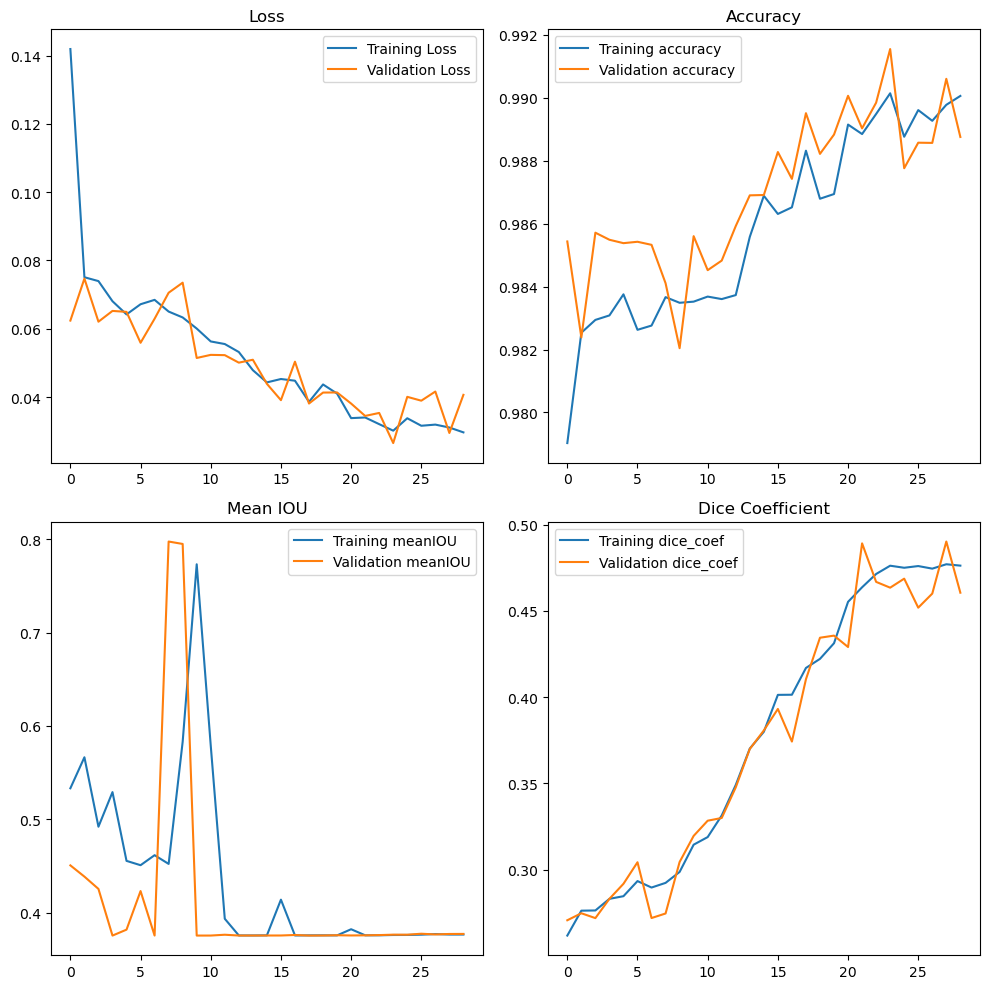

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history.history['loss'], label="Training Loss")
ax[0, 0].plot(history.history['val_loss'], label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(history.history['accuracy'], label="Training accuracy")
ax[0, 1].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[0, 1].set_title("Accuracy")
ax[0, 1].legend()

ax[1, 0].plot(history.history['mean_io_u'], label="Training meanIOU")
ax[1, 0].plot(history.history['val_mean_io_u'], label='Validation meanIOU')
ax[1, 0].set_title("Mean IOU")
ax[1, 0].legend()

ax[1, 1].plot(history.history['dice_coef'], label="Training dice_coef")
ax[1, 1].plot(history.history['val_dice_coef'], label='Validation dice_coef')
ax[1, 1].set_title("Dice Coefficient")
ax[1, 1].legend()

plt.tight_layout()

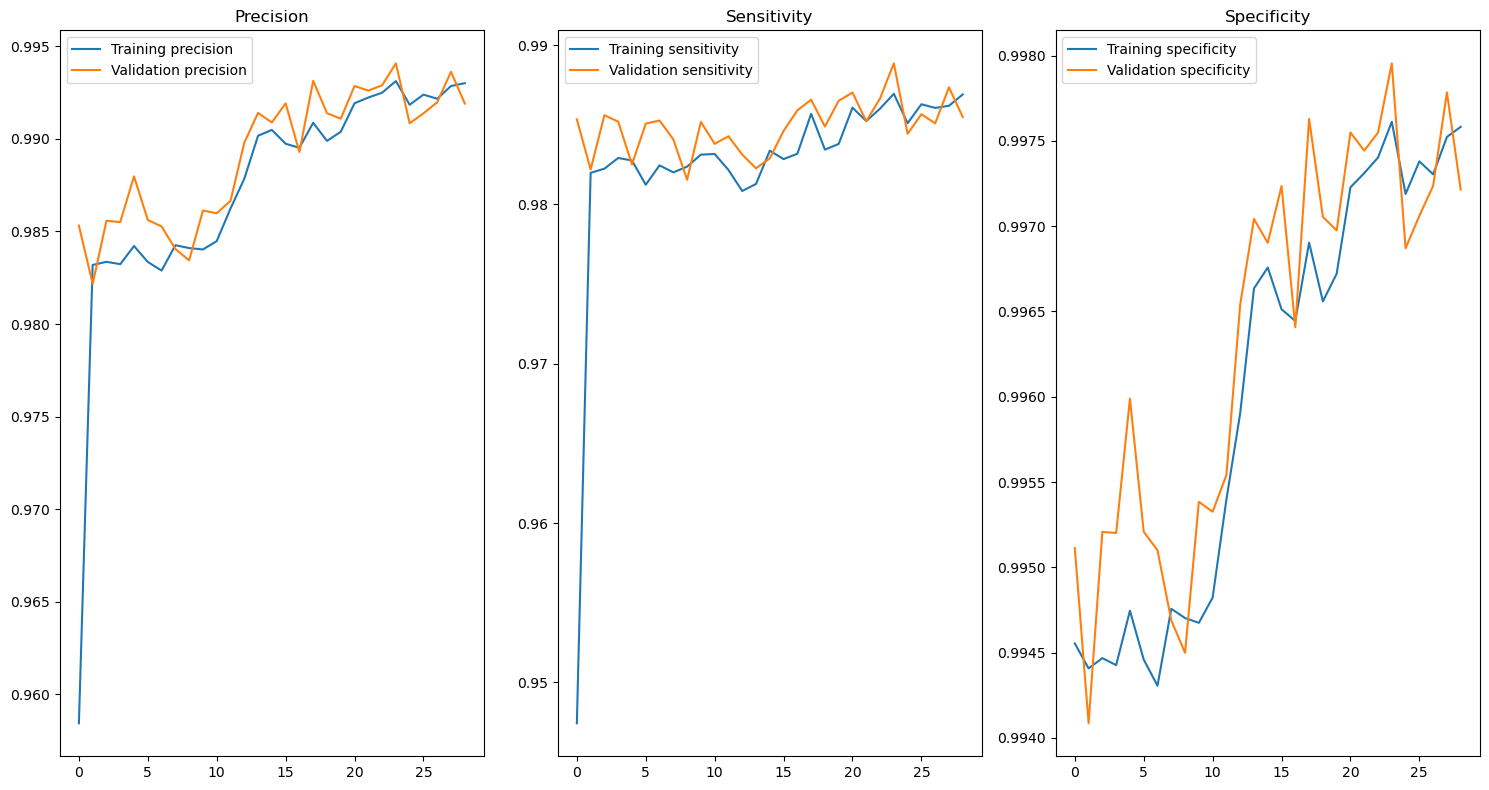

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].plot(history.history['precision'], label="Training precision")
ax[0].plot(history.history['val_precision'], label='Validation precision')
ax[0].set_title('Precision')
ax[0].legend()

ax[1].plot(history.history['sensitivity'], label="Training sensitivity")
ax[1].plot(history.history['val_sensitivity'], label='Validation sensitivity')
ax[1].set_title("Sensitivity")
ax[1].legend()

ax[2].plot(history.history['specificity'], label="Training specificity")
ax[2].plot(history.history['val_specificity'], label='Validation specificity')
ax[2].set_title("Specificity")
ax[2].legend()

plt.tight_layout()

In [23]:
def predict_tumors(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + "/" + case     
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    flair = nib.load(path + "/" + case + "_flair.nii").get_fdata()
    mask = nib.load(path + "/" + case + "_seg.nii").get_fdata()
    ce = nib.load(path + "/" + case + "_t1ce.nii").get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    pred = unet.predict(X/np.max(X), verbose=1)

    core = pred[:,:,:,1]
    edema= pred[:,:,:,2]
    enhancing = pred[:,:,:,3]

    f, ax = plt.subplots(2, 3) 

    for i in range(2): # for each image, add brain background
        for j in range(3):
            ax[i, j].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    ax[0, 0].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    ax[0, 0].title.set_text('Original image flair')
    
    mask=cv2.resize(mask[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    ax[0, 1].imshow(mask, cmap="Reds", interpolation='none', alpha=0.3)
    ax[0, 1].title.set_text('Ground truth')
    
    ax[0, 2].imshow(pred[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    ax[0, 2].title.set_text('all classes')
    
    ax[1, 0].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 0].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    
    ax[1, 1].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 1].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    
    ax[1, 2].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 2].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    
    plt.tight_layout()
    plt.show()
    print("\n")


4/4 [==============================] - 2s 125ms/step


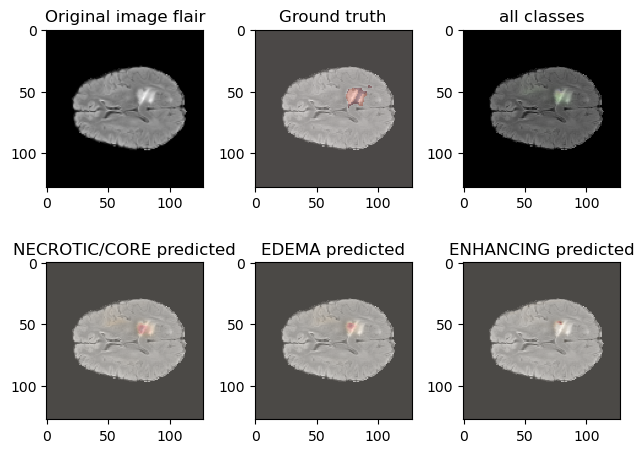



4/4 [==============================] - 0s 27ms/step


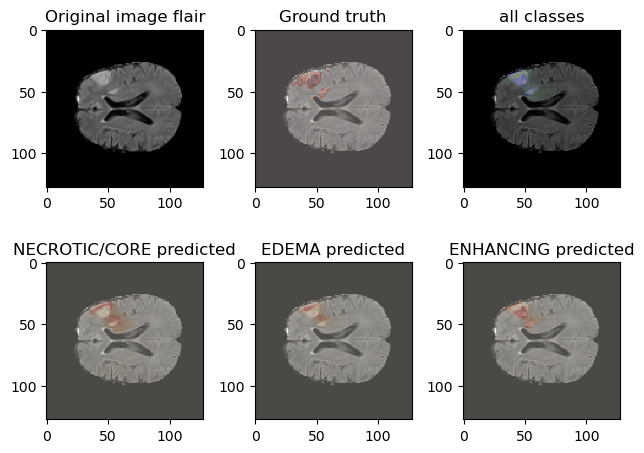



4/4 [==============================] - 0s 27ms/step


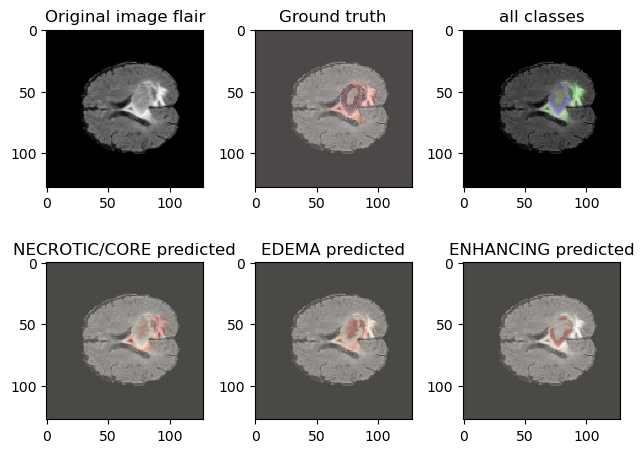



4/4 [==============================] - 0s 27ms/step


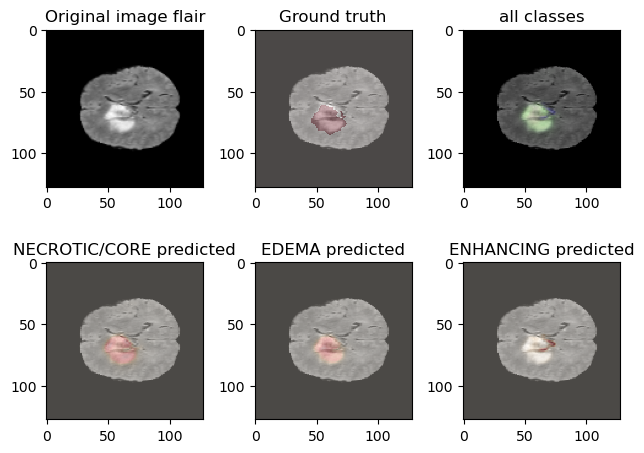



4/4 [==============================] - 0s 28ms/step


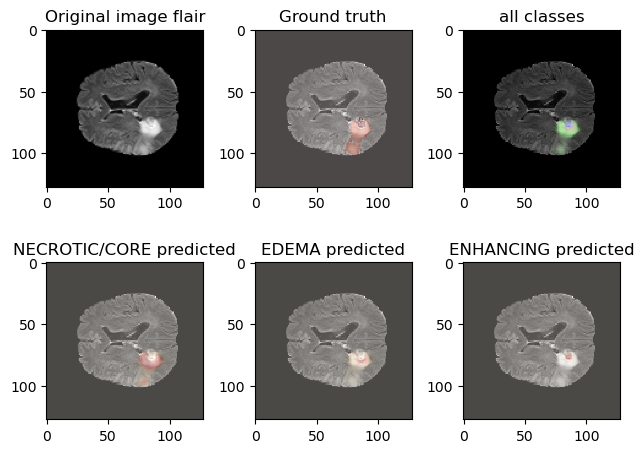

In [24]:
for ids in np.random.choice(train_ids, size=5, replace=False):
    predict_tumors(ids)

4/4 [==============================] - 0s 29ms/step


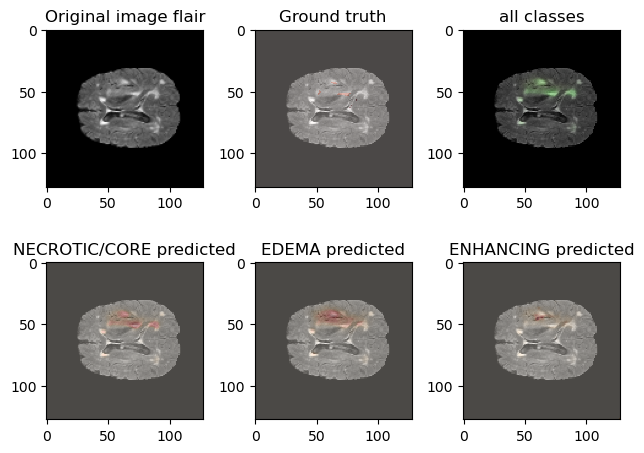



4/4 [==============================] - 0s 28ms/step


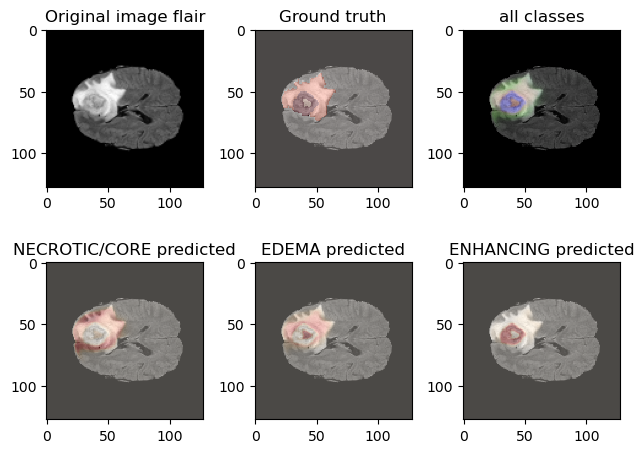



4/4 [==============================] - 0s 27ms/step


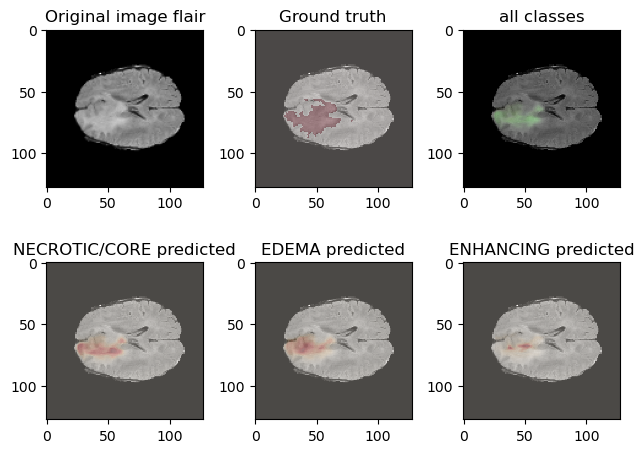



4/4 [==============================] - 0s 27ms/step


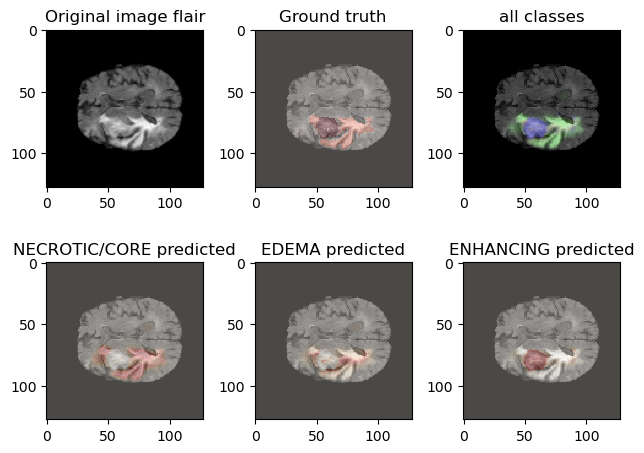



4/4 [==============================] - 0s 27ms/step


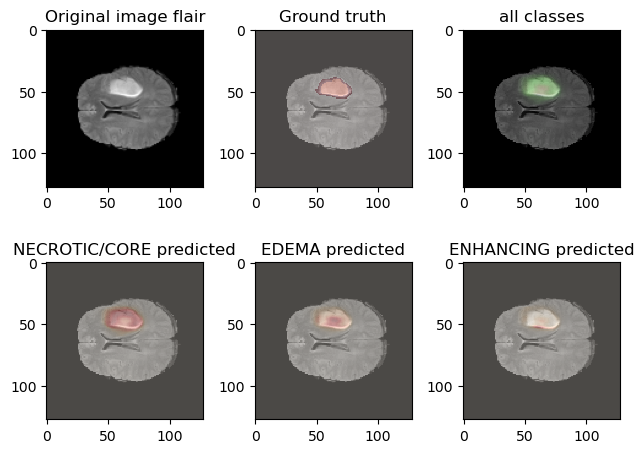

In [25]:
for ids in np.random.choice(val_ids, size=5, replace=False):
    predict_tumors(ids)

4/4 [==============================] - 0s 28ms/step


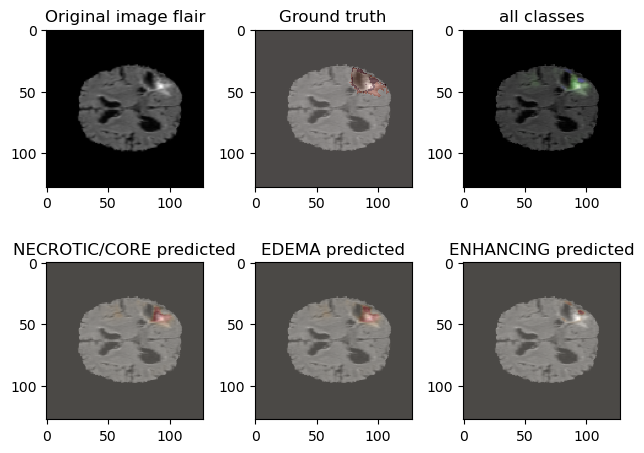



4/4 [==============================] - 0s 27ms/step


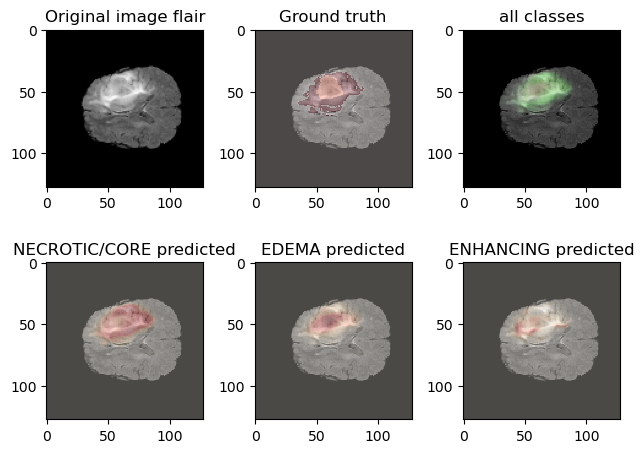



4/4 [==============================] - 0s 27ms/step


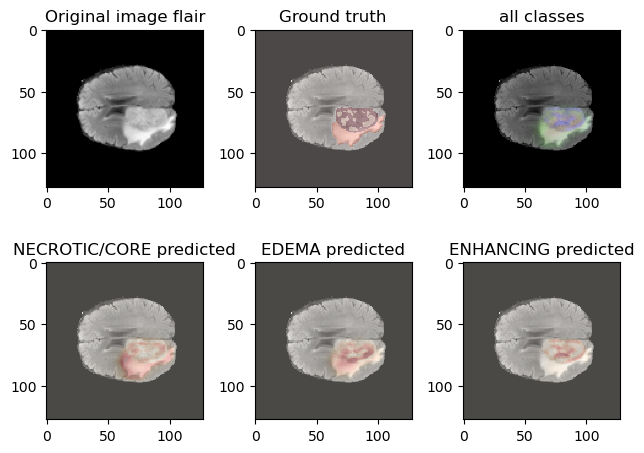



4/4 [==============================] - 0s 26ms/step


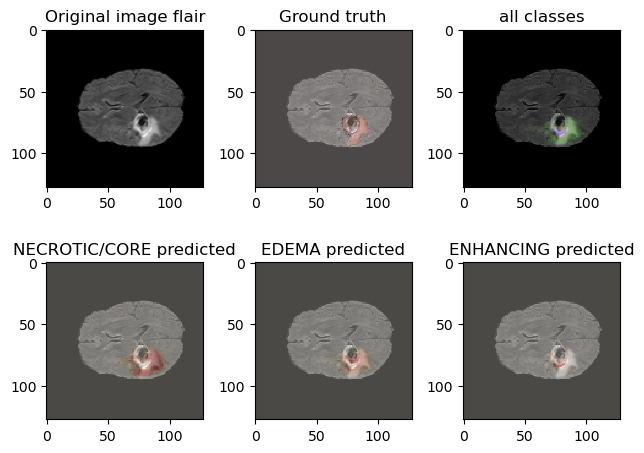



4/4 [==============================] - 0s 27ms/step


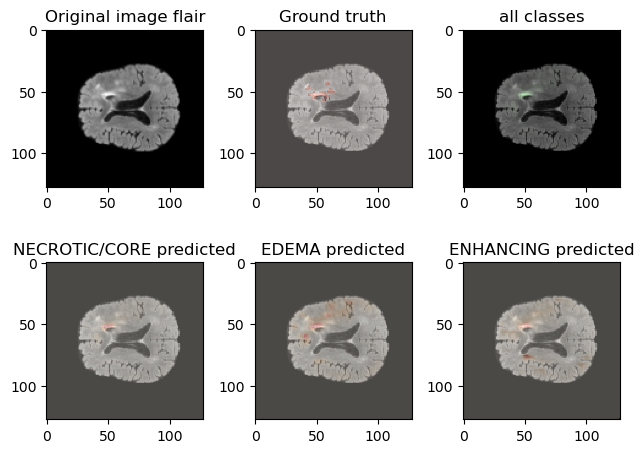

In [26]:
for ids in np.random.choice(test_ids, size=5, replace=False):
    predict_tumors(ids)

In [28]:
print("Evaluate on test data")
results = unet.evaluate(data_generator_wrapper(test_ids, batch_size=batch_size), 
                        steps=max(1, len(test_ids)//batch_size),batch_size=batch_size, callbacks= callbackss)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 18s 401ms/step - loss: 0.0357 - accuracy: 0.9887 - mean_io_u: 0.3763 - dice_coef: 0.4627 - precision: 0.9927 - sensitivity: 0.9841 - specificity: 0.9975 - dice_coef_necrotic: 0.3058 - dice_coef_edema: 0.5723 - dice_coef_enhancing: 0.4697
test loss, test acc: [0.035746198147535324, 0.9886749386787415, 0.3762856721878052, 0.4627031087875366, 0.9927247762680054, 0.9840509295463562, 0.997467577457428, 0.30575302243232727, 0.5723135471343994, 0.46974772214889526]
